<a href="https://colab.research.google.com/github/uofg-iom/CNN-Cropper/blob/main/Croppy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities.
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

# Properly install detectron2. (Please do not install twice in both ways)
# !python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 27.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyyaml: filename=PyYAML-5.1-cp39-cp39-linux_x86_64.whl size=44089 sha256=81cb0d4662ddbf0afa2b2b4f9919e02f85b229f50ccfdd473c20f9939ca8a554
  Stored in directory: /root/.cache/pip/wheels/68/be/8f/b6c454cd264e0b349b47f8ee00755511f277618af9e5dae20d
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 6.0
    Uninstalling PyYAML-6.0:
      Successfully uninstalled PyYAML-6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flax 0.6.8 requires PyYAML>=5.4.1, but you have pyyaml 5.1 which is incompatible.
dask 2022.12.1 requires pyyaml>=5.3.1, but you have pyyaml 5.1 which is incompatible.

In [2]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

ROOT = "/content/drive/My Drive/DSTP/"

Mounted at /content/drive


[04/26 12:25:55 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/My Drive/DSTP/model_final.pth ...
[{'file_name': '/content/drive/My Drive/DSTP/faces/validation/face16.jpg', 'height': 1280, 'width': 1920, 'annotations': [{'bbox': [897.3417721518988, 472.9113924050632, 1212.5316455696204, 642.5316455696202], 'bbox_mode': <BoxMode.XYXY_ABS: 0>, 'segmentation': [[897.3417721518988, 604.5569620253165, 902.4050632911393, 557.7215189873417, 917.5949367088608, 504.55696202531647, 973.2911392405065, 472.9113924050632, 1110.0, 475.44303797468353, 1202.4050632911394, 503.29113924050625, 1212.5316455696204, 575.4430379746835, 1211.2658227848103, 608.3544303797468, 1158.1012658227849, 596.9620253164557, 1084.6835443037976, 617.2151898734177, 1061.8987341772154, 642.5316455696202, 1025.1898734177216, 634.9367088607595, 1012.5316455696203, 609.620253164557, 953.0379746835445, 596.9620253164557]], 'category_id': 1, 'iscrowd': 0}, {'bbox': [893.5443037974685, 69

/usr/local/lib/python3.9/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


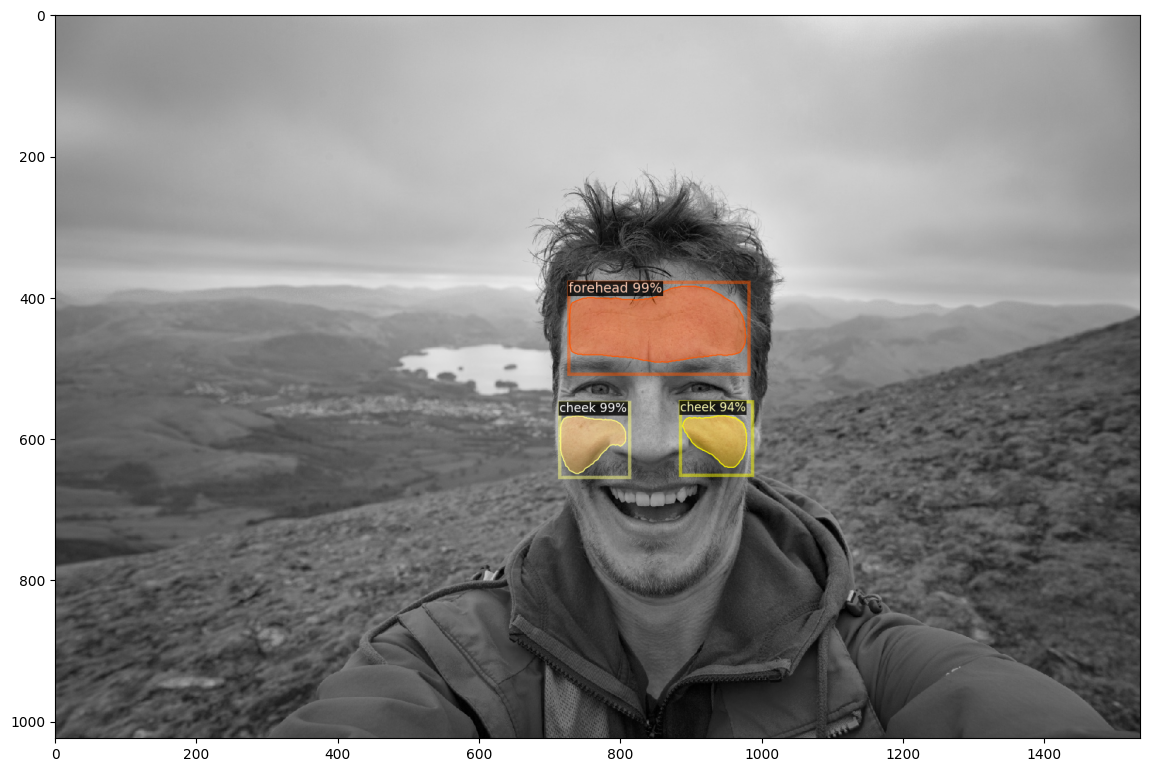

In [3]:
import os
import numpy as np
import json
from detectron2.structures import BoxMode
from detectron2.data import DatasetCatalog, MetadataCatalog

thing_classes = ['cheek','forehead']
thing_folder  = 'faces'

def get_labelled_dicts(directory):
    classes = thing_classes
    dataset_dicts = []
    for filename in [file for file in os.listdir(directory) if file.endswith('.json')]:
        json_file = os.path.join(directory, filename)
        with open(json_file) as f:
            img_anns = json.load(f)

        record = {}
        
        filename = os.path.join(directory, img_anns["imagePath"])
        
        record["file_name"] = filename
        record["height"] = img_anns["imageHeight"]
        record["width"] = img_anns["imageWidth"]
      
        annos = img_anns["shapes"]
        objs = []
        for anno in annos:
            px = [a[0] for a in anno['points']]
            py = [a[1] for a in anno['points']]
            poly = [(x, y) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": classes.index(anno['label']),
                "iscrowd": 0
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

for d in ["train", "test"]:
    DatasetCatalog.register(thing_folder+"_" + d, lambda d=d: get_labelled_dicts(ROOT+thing_folder+'/' + d))
    MetadataCatalog.get(thing_folder+"_" + d).set(thing_classes=thing_classes)
skins_metadata = MetadataCatalog.get(thing_folder+"_train")

cfg = get_cfg()

cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model

cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")

cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4
cfg.MODEL.WEIGHTS = os.path.join("/content/drive/My Drive/DSTP/model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5 
cfg.DATASETS.TEST = (thing_folder+"_test", )
predictor = DefaultPredictor(cfg)

import matplotlib.pyplot as plt
from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_labelled_dicts(ROOT+thing_folder+'/validation')
print(dataset_dicts)

for d in random.sample(dataset_dicts, 1):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=skins_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()

[array([ 892.5148 ,  686.0069 , 1015.9638 ,  818.95807], dtype=float32), array([ 909.25354,  473.55722, 1227.2489 ,  635.8079 ], dtype=float32), array([1106.5559,  684.6469, 1233.5956,  814.8951], dtype=float32)]


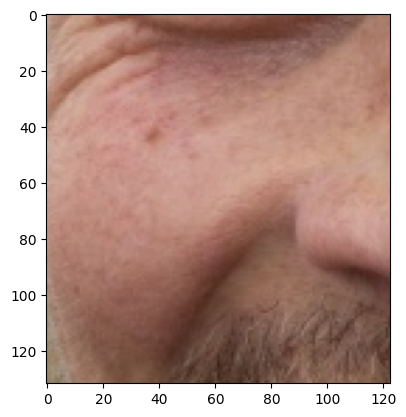

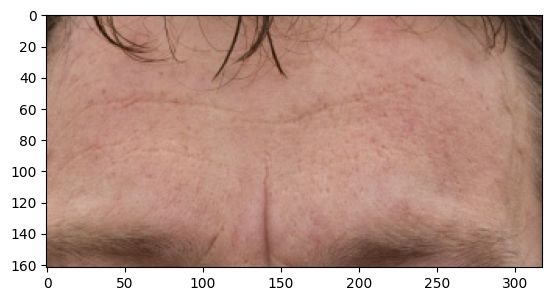

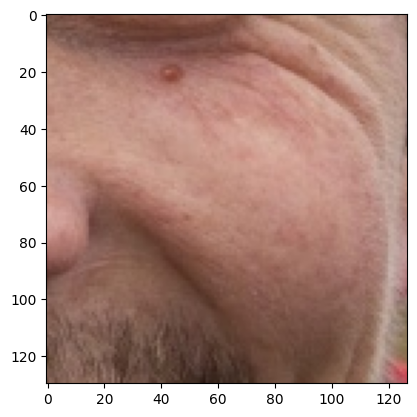

In [6]:
# [list(el2) for el2 in list(el)]
boxes = [el.numpy() for el in list(vars(outputs["instances"].to("cpu"))["_fields"]["pred_boxes"])]

print(boxes)
# print(im.shape)

def crop(box,im):
  box = [int(el) for el in box]
  # print(box)
  top = box[1]
  bottom = box[3]
  left = box[0]
  right = box[2]
  return im[top:bottom,left:right,:]
  

for i,box in enumerate(boxes):
  cropped = crop(box,im)
  plt.imshow(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB))
  plt.show()
  cv2.imwrite("/content/output/cropped"+str(i)+".png",cropped)


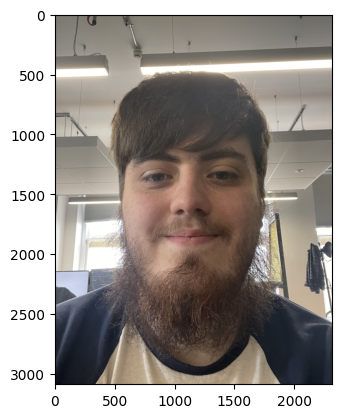

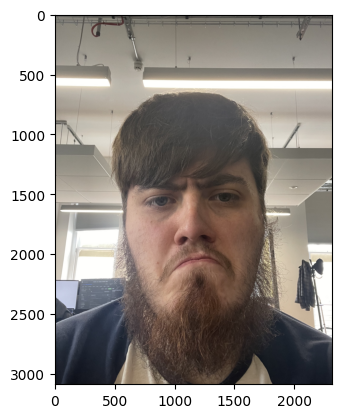

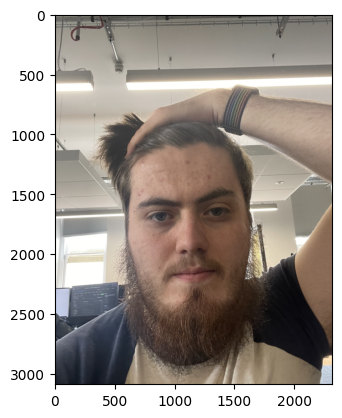

In [9]:
def predictAndCrop(filename,outputFolder="/content/output",outputName="cropped"):
  im = cv2.imread(filename)

  outputs = predictor(im)

  boxes = [el.numpy() for el in list(vars(outputs["instances"].to("cpu"))["_fields"]["pred_boxes"])]

  for i,box in enumerate(boxes):
    cropped = crop(box,im)
    # plt.imshow(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB))
    # plt.show()
    cv2.imwrite(os.path.join(outputFolder,outputName+str(i)+".png"),cropped)

predictAndCrop("/content/IMG_2942.png",outputName="outone")
predictAndCrop("/content/IMG_2943.png",outputName="outtwo")
predictAndCrop("/content/IMG_2944.png",outputName="outthree")

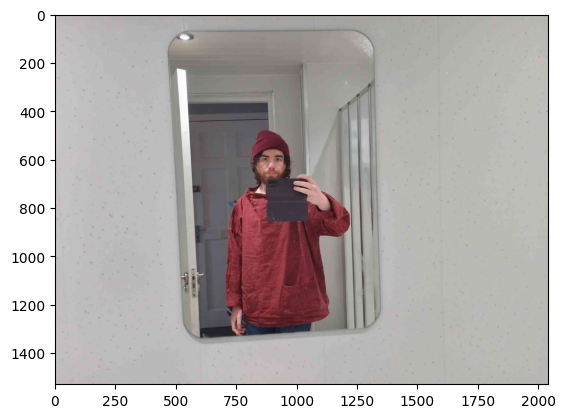

In [10]:
predictAndCrop("/content/IMG_20230426_114746_HDR.JPG",outputName="outfour")

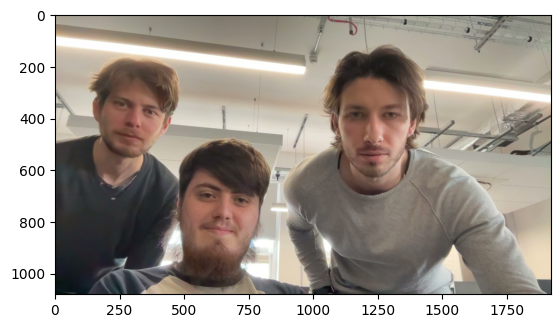

In [11]:
predictAndCrop("/content/Camera shot 2023-04-26 at 13.54.33.png",outputName="outfive")

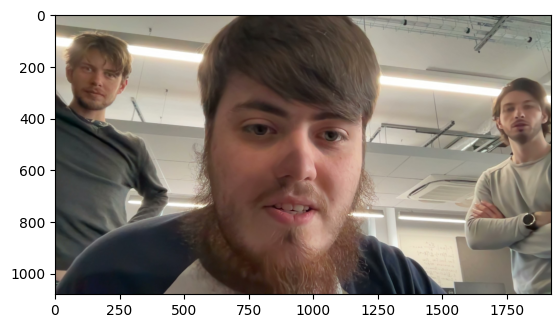

In [12]:
predictAndCrop("/content/Camera shot 2023-04-26 at 13.57.06.png",outputName="outfive")

In [13]:
!cp -r /content/output /content/drive/MyDrive/DSTP/croppedCheeks/